<a href="https://colab.research.google.com/github/daniivelascoo/ifp-programacion-ia/blob/main/Hito_1_Data_Analyst_Student.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 🏆 Hito 1: Proyecto Final Data Analyst (Spotify)

**Núcleo Formativo 1 - Programación de IA**

---
### 📜 Contexto del Negocio
Eres el **Lead Data Analyst** de una discográfica internacional. Tu director te ha dado acceso a dos bases de datos desconectadas:
1.  **Canciones (`df_tracks`):** Datos técnicos (duración, BPM, popularidad...).
2.  **Artistas (`df_artists`):** Datos de negocio (género, seguidores...).

### 🎯 Tu Misión
Tu trabajo consiste en realizar el ciclo completo de ingeniería de datos:
1.  **Limpiar** los errores detectados en los datos.
2.  **Fusionar** ambas tablas en un único dataset maestro.
3.  **Visualizar** los patrones ocultos.
4.  **Interpretar** los resultados para negocio.

---


In [1]:
# --- ⚙️ 0. CONFIGURACIÓN Y DATOS (NO TOCAR) ---
# Ejecuta esta celda para generar los datos simulados de Spotify.
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Configuración visual
sns.set_theme(style="whitegrid")

# Generador de Datos (Simulación)
def generar_datos():
    np.random.seed(42)
    n_tracks = 2000
    n_artists = 50

    # Tabla Artistas
    generos = ['Pop', 'Rock', 'Hip-Hop', 'Latino', 'Electronic', 'Jazz']
    artistas = pd.DataFrame({
        'artist_id': [f'ART_{i:03d}' for i in range(n_artists)],
        'name': [f'Artist_{i}' for i in range(n_artists)],
        'genre': np.random.choice(generos, n_artists),
        'followers': np.random.randint(10_000, 5_000_000, n_artists)
    })

    # Tabla Canciones
    tracks = pd.DataFrame({
        'track_id': [f'TRK_{i:05d}' for i in range(n_tracks)],
        'title': [f'Song_{i}' for i in range(n_tracks)],
        'artist_id': np.random.choice(artistas['artist_id'], n_tracks),
        'duration_ms': np.random.normal(200000, 30000, n_tracks).astype(int),
        'popularity': np.random.randint(0, 100, n_tracks).astype(float),
        'energy': np.random.uniform(0.4, 1.0, n_tracks),
        'danceability': np.random.uniform(0.3, 0.9, n_tracks)
    })

    # Introducir Suciedad
    tracks.loc[tracks.sample(frac=0.05).index, 'popularity'] = np.nan
    tracks.loc[tracks.sample(frac=0.01).index, 'duration_ms'] = -5000

    return tracks, artistas

df_tracks, df_artists = generar_datos()

print("✅ Datos cargados correctamente en memoria.")
print(f"   - Tracks: {df_tracks.shape}")
print(f"   - Artists: {df_artists.shape}")
print("\n--- VISTA PREVIA TRACKS (Con errores) ---")
display(df_tracks.head())

✅ Datos cargados correctamente en memoria.
   - Tracks: (2000, 7)
   - Artists: (50, 4)

--- VISTA PREVIA TRACKS (Con errores) ---


,track_id,title,artist_id,duration_ms,popularity,energy,danceability
0,TRK_00000,Song_0,ART_010,199233,13.0,0.910571,0.764551
1,TRK_00001,Song_1,ART_016,235181,36.0,0.607515,0.693722
2,TRK_00002,Song_2,ART_007,216308,78.0,0.421129,0.582998
3,TRK_00003,Song_3,ART_034,188881,67.0,0.847708,0.642977
4,TRK_00004,Song_4,ART_034,223150,39.0,0.881223,0.327842


---
## 🧹 PARTE A: Ingeniería de Datos (Pandas)

### 1. Limpieza de Datos
*   Rellena los nulos de `popularity` con la **mediana**.
*   Corrige los valores negativos de `duration_ms` (valor absoluto).
*   Crea la columna `duration_min` (minutos).

In [4]:
# 1.1. Rellenar Nulos
mediana_pop = df_tracks['popularity'].mean()
df_tracks['popularity'] = df_tracks['popularity'].fillna(mediana_pop)

# 1.2. Corregir Duración
df_tracks['duration_ms'] = df_tracks['duration_ms'].abs()

# 1.3. Ingeniería de Features
df_tracks['duration_min'] = df_tracks['duration_ms'] / 60000

print("Limpieza completada.")
print(f"Nulos restantes: {df_tracks['popularity'].isnull().sum()}")

Limpieza completada.
Nulos restantes: 0


### 2. Fusión de Datos (Merge)
Une las canciones con sus artistas usando `artist_id`. Usa un `left` join.

In [5]:
df_full = pd.merge(
    left=df_tracks,
    right=df_artists,
    on='artist_id',
    how='left'
)

print(f"Dataset Maestro creado. Dimensiones: {df_full.shape}")

Dataset Maestro creado. Dimensiones: (2000, 11)


### 📝 REFLEXIÓN DE NEGOCIO (Obligatorio)
*Haz doble clic aquí para editar.*

**Pregunta:** ¿Por qué hemos usado un `LEFT JOIN` en lugar de un `INNER JOIN`? ¿Qué pasaría con las canciones si su artista no estuviera en la base de datos de artistas?

**Respuesta:** Hemos utiliza `LEFT JOIN` para asegurar que tdas las canciones del dataset principal (df_tracks) se mantengan, incluso si no existe información del artista en la tabla de artistas. Si hubieramos usado un `INNER JOIN`, solo se conservarían las canciones cuyo artist_id coincida en abmas tablas, y se perderian aquellas canciones cuyo artista no este registrado.


### 3. Agrupación (Analysis)
Agrupa por `genre` y calcula la media de `popularity` y `energy`.

In [6]:
df_resumen = df_full.groupby('genre')[['popularity', 'energy']].mean()
df_resumen = df_resumen.sort_values('popularity', ascending=False)
display(df_resumen)

,popularity,energy
genre,,
Pop,50.880743,0.689311
Rock,50.195429,0.701466
Electronic,49.858449,0.706973
Hip-Hop,49.270512,0.702890
Latino,49.046347,0.683602
Jazz,48.601538,0.697970


---
## 🎨 PARTE B: Visualización (Seaborn)

### 4. Distribución de Popularidad (Histograma)

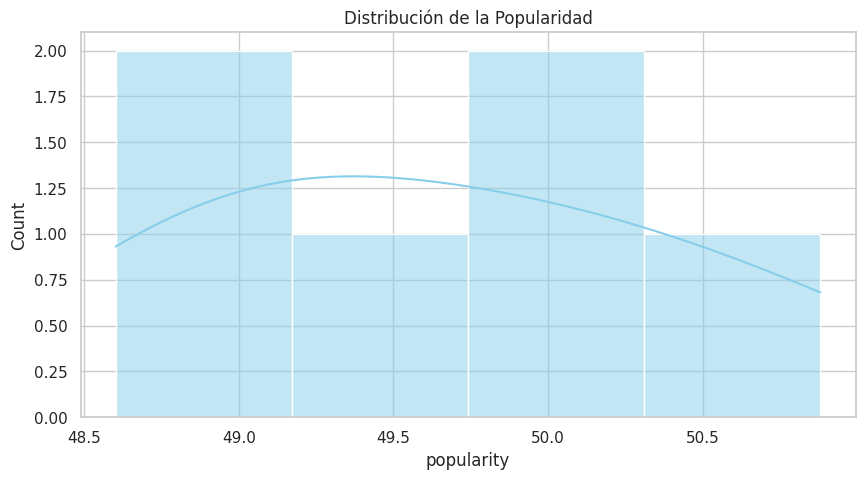

In [7]:
plt.figure(figsize=(10, 5))
sns.histplot(data=df_resumen, x='popularity', kde=True, color='skyblue')
plt.title("Distribución de la Popularidad")
plt.show()

### 5. Energía por Género (Boxplot)

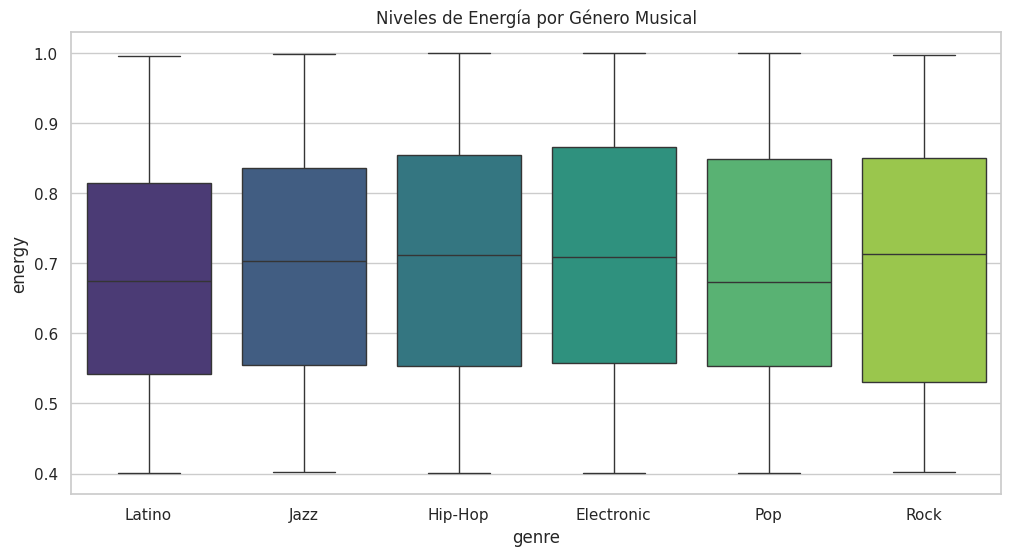

In [15]:
plt.figure(figsize=(12, 6))
sns.boxplot(data=df_full, x='genre', y='energy', hue='genre', palette='viridis', legend=False)
plt.title("Niveles de Energía por Género Musical")
plt.show()

### 📝 REFLEXIÓN DE NEGOCIO (Obligatorio)
*Haz doble clic aquí para editar.*

**Pregunta:** Observando el Boxplot de arriba, si tuvieras que crear una lista de reproducción para un gimnasio (alta energía constante), ¿qué género elegirías y por qué?

**Respuesta:** Elegiría Electronic o Rock porque presentan niveles de energía más altos y constantes.

---
## ⭐ PARTE C: BONUS TRACK (Excelencia)
**Objetivo:** Para optar a la máxima nota (10), debes realizar esta misión sin ayuda de huecos.

**Misión:** Crea un **Mapa de Calor (Heatmap)** que muestre la correlación entre las variables numéricas:
`['popularity', 'energy', 'danceability', 'duration_min']`.

1.  Crea un sub-dataframe solo con esas columnas.
2.  Calcula la matriz de correlación (`.corr()`).
3.  Pinta el heatmap con anotaciones (`annot=True`).

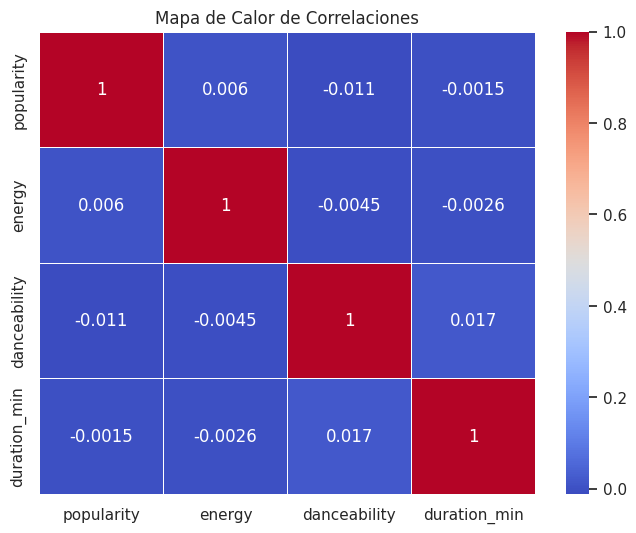

In [21]:
# TU CÓDIGO AQUÍ (Sin huecos, demuestra lo que sabes)

cols = ['popularity', 'energy', 'danceability', 'duration_min']
df_corr = df_full[cols]

# Matriz de correlación
corr_matrix = df_corr.corr()

# Heatmap
plt.figure(figsize=(8,6))
sns.heatmap(
    corr_matrix,
    annot=True,      # muestra los valores
    cmap='coolwarm',
    linewidths=0.5
)

plt.title("Mapa de Calor de Correlaciones")
plt.show()

## 🏁 VALIDACIÓN FINAL

# Ejecuta la celda de abajo.


In [20]:
# --- 🤖 CÓDIGO DE VALIDACIÓN (NO MODIFICAR) ---
def validar_hito_1():
    print("🚀 AUDITANDO HITO 1 (DATA ANALYST)...\n")
    puntos = 0
    errores = []

    v_full = globals().get('df_full')
    v_resumen = globals().get('df_resumen')

    # 1. PANDAS
    if v_full is not None:
        if 'genre' in v_full.columns and 'duration_min' in v_full.columns:
            if v_full['popularity'].isnull().sum() == 0 and v_full['duration_ms'].min() >= 0:
                print("✅ [PARTE A] Ingeniería de Datos: CORRECTO.")
                puntos += 3
            else:
                errores.append("❌ Aún hay nulos o errores en los datos.")
        else:
            errores.append("❌ Faltan columnas clave.")
    else:
        errores.append("❌ No existe 'df_full'.")

    # 2. VISUALIZACIÓN
    historial = "\n".join(globals().get('_ih', []))
    graficos = 0
    if 'histplot' in historial: graficos += 1
    if 'boxplot' in historial: graficos += 1

    if graficos >= 2:
        print("✅ [PARTE B] Gráficos Base: CORRECTO.")
        puntos += 3
    else:
        errores.append(f"❌ Faltan gráficos base (Hist/Box).")

    # 3. BONUS (Heatmap)
    if 'heatmap' in historial and 'corr' in historial:
        print("🌟 [PARTE C] BONUS TRACK: ¡Excelente! Heatmap detectado.")
        puntos += 2
    else:
        print("ℹ️ [PARTE C] No se ha detectado el Bonus Track (Heatmap).")

    # REPORTE
    print("\n" + "="*50)
    # Nota: Los 2 puntos restantes hasta 10 dependen de las respuestas de texto (Reflexión)
    if puntos >= 6:
        import hashlib
        code = hashlib.md5(str(len(v_full)).encode()).hexdigest()[:8].upper()
        print(f"🏆 PROYECTO APTO PARA ENTREGA.")
        print(f"Puntuación Automática: {puntos}/8 (El profesor evaluará las reflexiones)")
        print(f"🔐 CÓDIGO DE ENTREGA: ANALYST-{code}")
    else:
        print("⚠️ NO APTO. Revisa los errores.")
        for e in errores: print(f"   - {e}")
    print("="*50)

validar_hito_1()

🚀 AUDITANDO HITO 1 (DATA ANALYST)...

✅ [PARTE A] Ingeniería de Datos: CORRECTO.
✅ [PARTE B] Gráficos Base: CORRECTO.
🌟 [PARTE C] BONUS TRACK: ¡Excelente! Heatmap detectado.

🏆 PROYECTO APTO PARA ENTREGA.
Puntuación Automática: 8/8 (El profesor evaluará las reflexiones)
🔐 CÓDIGO DE ENTREGA: ANALYST-08F90C1A
